<a href="https://colab.research.google.com/github/AlvarDev/Gemini-is-all-you-need/blob/main/Gemini_is_all_you_need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Based on https://github.com/GoogleCloudPlatform/generative-ai/tree/main

# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini é tudo o que você precisa

[Add Shorcuts to open by their own]

# Setup

### Instalar o SDK da Vertex AI e BigQuery para Python


In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 36.6 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Reinicie o Runtime
Para usar os pacotes recém-instalados neste runtime do Jupyter, você deve reiniciar o runtime. Você pode fazer isso executando a seguinte célula, que irá reiniciar o kernel atual.


In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Authenticate your notebook environment (Colab only)
Se você estiver executando este notebook no Google Colab, execute a célula a seguir para autenticar seu ambiente. Esta etapa não é necessária se você estiver usando o [Vertex AI Workbench](https://cloud.google.com/vertex-ai-notebooks?hl=en).

In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Defina as informações do projeto do Google Cloud e inicialize o Vertex AI
Inicialize o SDK da Vertex AI para Python para seu projeto:

In [ ]:
# Define project information
PROJECT_ID = "sre-demos"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI and BigQuery
from google.cloud import bigquery
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)


### Import libraries

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import PIL
import requests
from PIL import Image as PILImage  # Explicit import for clarity
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
from vertexai.vision_models import (
    Image as VMImage,
    MultiModalEmbeddingModel,
    MultiModalEmbeddingResponse,
    Video as VMVideo,
    VideoSegmentConfig,
)
from base64 import b64encode
from IPython.display import Markdown
from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image,
    Part,
)

pd.options.mode.chained_assignment = None  # default='warn'

#### Definir funções auxiliares para imagens

In [ ]:
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def display_content_as_image(content: str | Image | Part) -> bool:
    if not isinstance(content, Image):
        return False
    display_images([content])
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    if not isinstance(content, Part):
        return False
    part = typing.cast(Part, content)
    file_path = part.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{file_path}"
    IPython.display.display(IPython.display.Video(video_url, width=600))
    return True


def print_multimodal_prompt(contents: list[str | Image | Part]):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)

In [ ]:
MODEL_ID = "gemini-1.5-flash-001"

multimodal_model = GenerativeModel(
    MODEL_ID,
    system_instruction=[
        "Você é um especialista em ropa e moda",
        "Você se orgulha de sua incrível precisão e atenção aos detalhes.",
        "Sua missão é ajudar aos clientes",
    ],
)

mm_embedding_model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding")


In [ ]:
prompt = """
O cliente mandou um video da roupa que ele gostou,
você tem que identificar o segundo com decimais onde essa roupa aparece,
a roupa não pode estar cortado e a roupa tem que estar no medio do frame,
deves descrever a roupa a detalhe.

Preciso que a sua resposta seja neste formato JSON:

{
  "seconds": 0,
  "description": ""
}


A descrição do cliente foi:
Eu gostei do moletom que esta na cama
"""
video = Part.from_uri(
    uri="gs://gemini-demos-bucket/io-demo.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

response = multimodal_model.generate_content(contents)
json_string = response.text
json_string = json_string.replace("```json", "")
json_string = json_string.replace("```", "")
roupa = json.loads(json_string)

print("\n-------Response--------")
print(roupa)



-------Response--------
{'seconds': 3.2, 'description': 'O moletom é cinza escuro com mangas compridas,  uma gola redonda e uma estampa colorida na parte frontal. A estampa é composta por um desenho colorido com vários detalhes e cores vibrantes. A roupa está bem centralizada no frame e totalmente visível.'}


In [ ]:
import cv2

def extract_frame_at_second(video_path, target_second, save_path=None):
  """Extracts a frame from the video at the specified second.

  Args:
      video_path (str): Path to the video file.
      target_second (float): The second at which to extract the frame.

  Returns:
      bool: True if the frame was extracted successfully, False otherwise.
      numpy.ndarray: The extracted frame (if successful), None otherwise.
  """

  cap = cv2.VideoCapture(video_path)

  if not cap.isOpened():
    print("Error opening video file!")
    return False, None

  # Get frame rate
  fps = cap.get(cv2.CAP_PROP_FPS)

  # Calculate frame number at target second (rounded to nearest frame)
  target_frame = int(round(target_second * fps))

  # Check if target frame is within video bounds
  num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  if target_frame >= num_frames:
    print(f"Target second ({target_second}) exceeds video length ({num_frames / fps} seconds).")
    return False, None

  # Set frame position
  cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)

  # Read the frame
  ret, frame = cap.read()

  # Release the video capture object
  cap.release()

  if ret:
    if save_path:
      # Save the frame
      cv2.imwrite(save_path, frame)
      print(f"Frame saved to: {save_path}")
    return True, frame
  else:
    print("Error reading frame!")
    return False, None

Frame saved to: my_frame.jpg


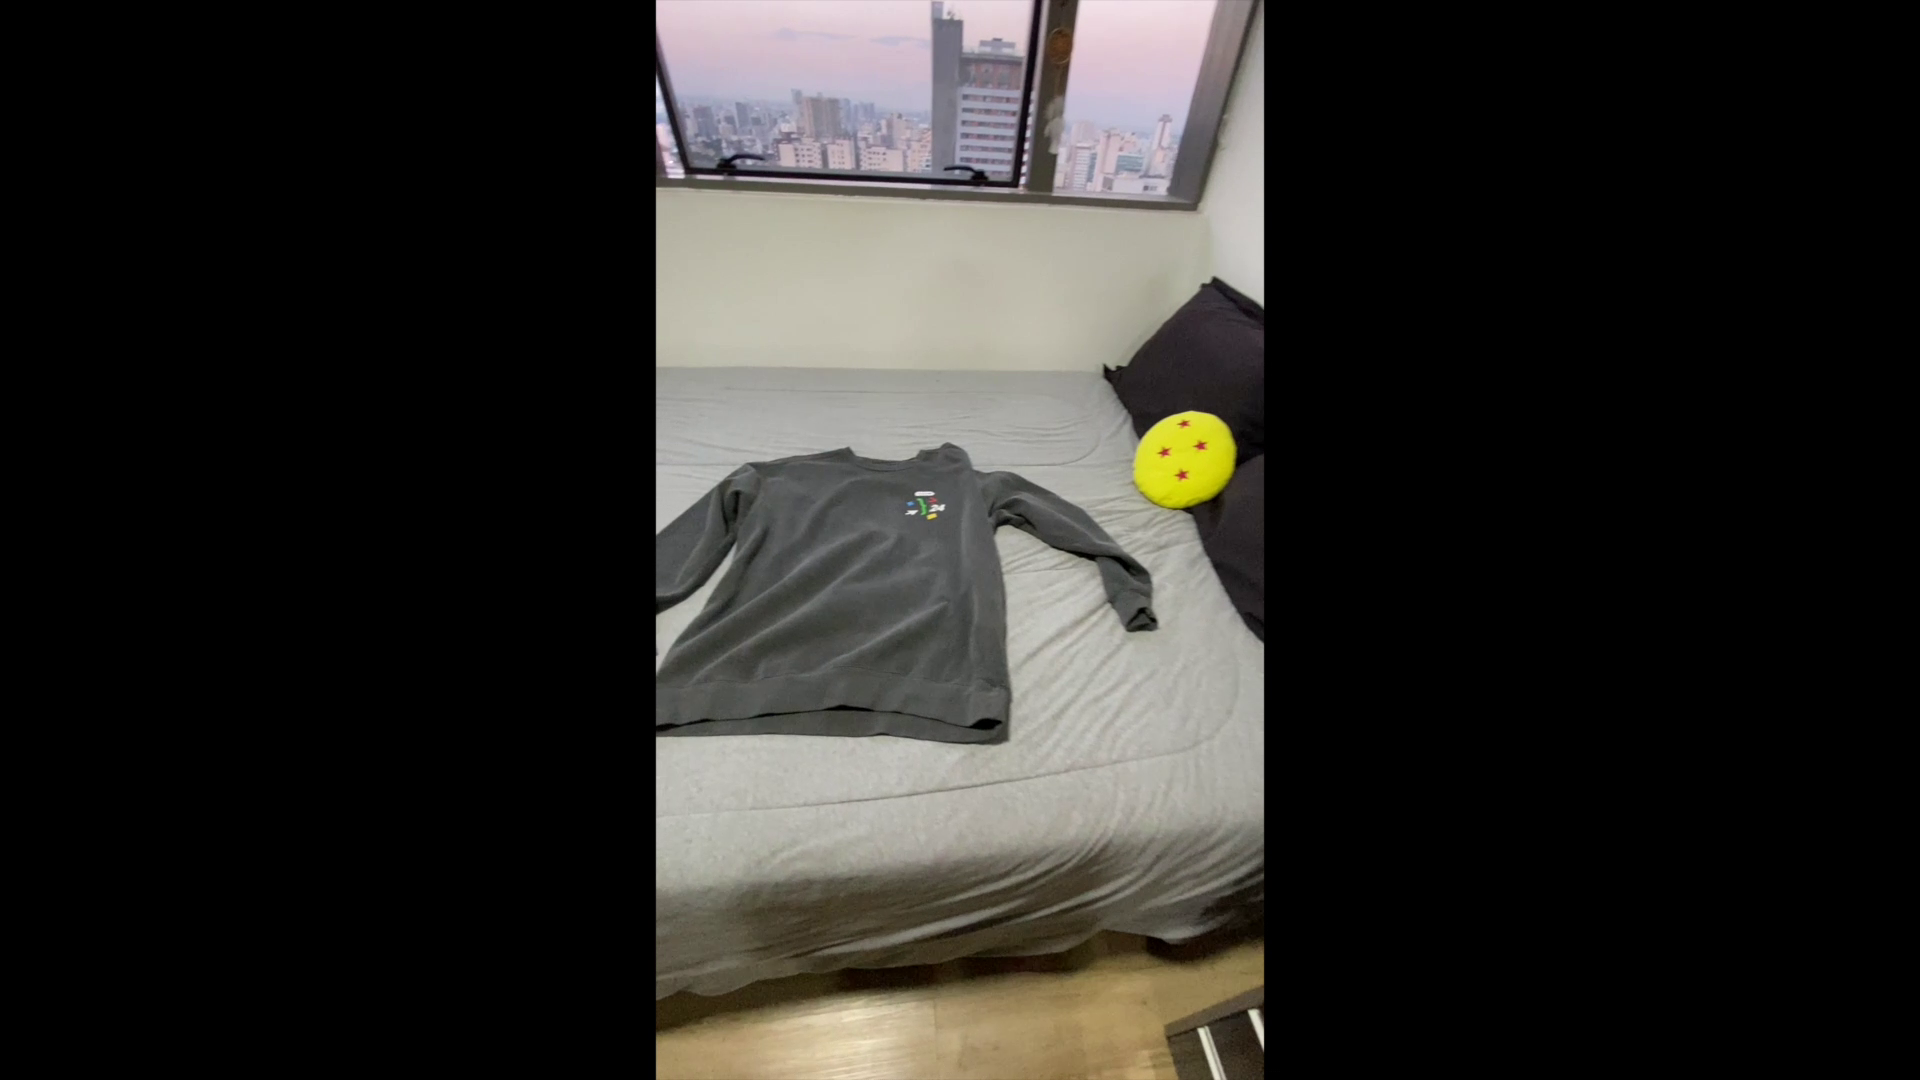

Frame extracted successfully!
{'seconds': 3.2, 'description': 'O moletom é cinza escuro com mangas compridas,  uma gola redonda e uma estampa colorida na parte frontal. A estampa é composta por um desenho colorido com vários detalhes e cores vibrantes. A roupa está bem centralizada no frame e totalmente visível.', 'frame_path': 'my_frame.jpg'}


In [ ]:
from google.colab.patches import cv2_imshow as tmr
# Example usage
video_path = "io-demo.mp4"
frame_path = "my_frame.jpg"
target_second = roupa["seconds"] + 1.5  # Adding 1.5

success, extracted_frame = extract_frame_at_second(video_path, target_second, frame_path)

if success:
  tmr(extracted_frame)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  print("Frame extracted successfully!")
else:
  print("Failed to extract frame.")

roupa.update({"frame_path": frame_path})
print(roupa)

In [ ]:
def get_image_video_text_embeddings(
    image_path: Optional[str] = None,
    video_path: Optional[str] = None,
    contextual_text: Optional[str] = None,
    dimension: Optional[int] = 1408,
    video_segment_config: Optional[VideoSegmentConfig] = None,
    debug: bool = False,
) -> MultiModalEmbeddingResponse:
    """Generates multimodal embeddings from image, video, and text.

    Args:
        image_path: Path to image (local or Google Cloud Storage).
        video_path: Path to video (local or Google Cloud Storage).
        contextual_text: Text to generate embeddings for. Max: 32 tokens (~32 words).
        dimension: Dimension of the returned embeddings (128, 256, 512, or 1408).
        video_segment_config: Defines specific video segments for embedding generation.
        debug: If True, print debugging information.

    Returns:
        MultiModalEmbeddingResponse: The generated embeddings.

    Raises:
        ValueError: If neither image_path, video_path, nor contextual_text is provided.
    """

    # Input validation
    if not any([image_path, video_path, contextual_text]):
        raise ValueError(
            "At least one of image_path, video_path, or contextual_text must be provided."
        )

    image = VMImage.load_from_file(image_path) if image_path else None
    video = VMVideo.load_from_file(video_path) if video_path else None

    embeddings = mm_embedding_model.get_embeddings(
        image=image,
        video=video,
        video_segment_config=video_segment_config,
        contextual_text=contextual_text,
        dimension=dimension,
    )

    # Prepare result dictionary for better organization
    result = {}

    if image_path:
        if debug:
            print(
                f"\n\nImage Embedding (first five):\n{embeddings.image_embedding[:5]}"
            )
            print(f"Dimension of Image Embedding: {len(embeddings.image_embedding)}")
        result["image_embedding"] = embeddings.image_embedding

    if video_path:
        if debug:
            print("Video Embeddings:")
        video_embedding_list = [
            {
                "start_offset_sec": video_embedding.start_offset_sec,
                "end_offset_sec": video_embedding.end_offset_sec,
                "embedding": video_embedding.embedding,
            }
            for video_embedding in embeddings.video_embeddings
        ]
        result["video_embeddings"] = video_embedding_list

        if debug:
            for embedding in video_embedding_list:
                print(
                    f"\nVideo Segment (in seconds): {embedding['start_offset_sec']} - {embedding['end_offset_sec']}"
                )
                print(f"Embedding (first five): {embedding['embedding'][:5]}")
                print(f"Dimension of Video Embedding: {len(embedding['embedding'])}")

    if contextual_text:
        if debug:
            print(f"\n\nText Embedding (first five):\n{embeddings.text_embedding[:5]}")
            print(f"Dimension of Text Embedding: {len(embeddings.text_embedding)}")
        result["text_embedding"] = embeddings.text_embedding

    return result

In [ ]:
# Image embeddings with default 1408 dimension
result = get_image_video_text_embeddings(
    image_path=roupa["frame_path"],
    contextual_text=roupa["description"],
    debug=True,
)

print(result)



Image Embedding (first five):
[0.0265977252, -0.0359898098, 0.0115761543, -0.0201556366, 0.00847359654]
Dimension of Image Embedding: 1408


Text Embedding (first five):
[0.0269105211, -0.0624977164, 0.00765265385, 0.00573607627, 0.0388032049]
Dimension of Text Embedding: 1408
{'image_embedding': [0.0265977252, -0.0359898098, 0.0115761543, -0.0201556366, 0.00847359654, -0.0114668943, -0.0271535423, 0.00355971488, 0.0117343944, -0.0540779866, 0.0221800432, 0.000802202791, 0.00488753524, 0.0791961625, -0.0292536281, -0.0173111819, -0.0378879346, 0.0199284367, -0.0107798548, -0.0230124537, -0.036665637, -0.0230907127, 0.037054576, 0.0531911515, 0.0187491793, -0.00730141951, 0.0167238582, 0.01006182, -0.03804316, -0.00593691505, 0.0153424582, -0.0144182201, 0.0136183091, -0.00921070483, -0.0369551368, -0.00457598502, -0.003733424, -0.0206382889, -0.0237616692, -0.00990178809, 0.0271186624, -0.0304858927, 0.0102355815, 0.00507380487, 0.0188871063, -0.010242207, -0.031556949, 0.0144167542,

In [ ]:
image_data_with_embeddings = pd.read_csv(
    "https://storage.googleapis.com/github-repo/embeddings/getting_started_embeddings/image_data_with_embeddings.csv"
)  # dimensions; image = 1408, text = 768
image_data_with_embeddings.head()

,parent_sku,parent_description,retail_price,img_url,seo_url,title,shortdesc,longdesc,keywords,metadescription,file_path,gcs_path,combined_text,image_embeddings,text_embeddings
0,GGOEAXXX1947,Android Keyboard Sticker,2.0,https://shop.googlemerchandisestore.com/store/...,https://shop.googlemerchandisestore.com/Google...,Android Keyboard Sticker,Add some character to your keyboard! This sma...,"<div><p dir=""ltr""><span>Sticker measures ½ x ...",Android Keyboard Sticker,Shop Google Merchandise store for Android Keyb...,/content/data/gms_images/GGOEAFKA194799.jpg,gs://github-repo/embeddings/getting_started_em...,Android Keyboard Sticker Android Keyboard Stic...,"[-0.019712951, -0.00683932705, 0.0385046713, 0...","[-0.0003441123408265412, -0.020794985815882683..."
1,GGOEGXXX1238,Google Pen Neon Coral,2.0,https://shop.googlemerchandisestore.com/store/...,https://shop.googlemerchandisestore.com/Google...,Google Pen Neon Coral,Whether you are signing official documents or ...,<div><p>Soft touch surface.</p><p>Fine point g...,"Google Pen Neon Coral, Google, pen, orange, co...",Shop Google Merchandise Store for Google Pen N...,/content/data/gms_images/GGOEGOAN123899.jpg,gs://github-repo/embeddings/getting_started_em...,"Google Pen Neon Coral Google Pen Neon Coral, G...","[0.0312964357, 0.0266801305, -0.00428772392, 0...","[0.015119598247110844, -0.05192413181066513, -..."
2,GGOEGXXX1983,Google Hologram Sunnyvale Campus Sticker,2.0,https://shop.googlemerchandisestore.com/store/...,https://shop.googlemerchandisestore.com/Google...,Google Hologram Sunnyvale Campus Sticker,"Nostalgic and fun for everyone, our exclusive ...","<div><p dir=""ltr""><span>Sticker measures 3 H</...",Google Hologram Sunnyvale Campus Sticker,Shop Google Merchandise store for Google Holog...,/content/data/gms_images/GGOEGCKA198399.jpg,gs://github-repo/embeddings/getting_started_em...,Google Hologram Sunnyvale Campus Sticker Googl...,"[-0.0115588326, 0.0233894847, 0.0509909727, 0....","[0.008340244181454182, -0.019928857684135437, ..."
3,GGOEGXXX1773,Google Maps Wheat Pen,2.0,https://shop.googlemerchandisestore.com/store/...,https://shop.googlemerchandisestore.com/Google...,Google Maps Wheat Pen,Drop your pen to paper and start planning your...,<div><p>Black Ink </p><p>Retractable medium ba...,Google Maps Wheat Pen,Shop Google Merchandise Store for Google Maps ...,/content/data/gms_images/GGOEGOAB177399.jpg,gs://github-repo/embeddings/getting_started_em...,Google Maps Wheat Pen Google Maps Wheat Pen Sh...,"[0.0108120618, 0.0177407321, -0.0159502737, 0....","[0.0009172282880172133, -0.05302327498793602, ..."
4,GGOECXXX1946,Google Cloud Keyboard Sticker,2.0,https://shop.googlemerchandisestore.com/store/...,https://shop.googlemerchandisestore.com/Google...,Google Cloud Keyboard Sticker,Add some character to your keyboard! This sma...,"<div><p dir=""ltr""><span>Sticker measures ½ x ...",Google Cloud Keyboard Sticker,Shop Google Merchandise store for Google Cloud...,/content/data/gms_images/GGOECFKA194699.jpg,gs://github-repo/embeddings/getting_started_em...,Google Cloud Keyboard Sticker Google Cloud Key...,"[-0.0243009, 0.0230779219, 0.039797049, 0.0337...","[0.015464423224329948, -0.025598861277103424, ..."


In [ ]:
from IPython.display import Image as ImageByte, display


def get_url_from_gcs(gcs_uri: str) -> str:
    """Converts a Google Cloud Storage (GCS) URI to a publicly accessible URL.

    Args:
        gcs_uri: The GCS URI in the format gs://bucket-name/object-name.

    Returns:
        The corresponding public URL for the object.
    """
    return gcs_uri.replace("gs://", "https://storage.googleapis.com/").replace(
        " ", "%20"
    )


def print_shortlisted_products(
    shortlisted_products: Union[Dict, Any], display_flag: bool = False
) -> None:
    """Prints information about shortlisted products, optionally displaying images.

    Args:
        shortlisted_products: A dictionary-like object containing product data with 'score' and 'gcs_path' keys.
        display_flag: If True, displays images of the products using IPython.
    """
    print("Similar product identified ---- \n")

    for (
        index,
        product,
    ) in shortlisted_products.iterrows():  # Iterate directly over rows for clarity
        score = product["score"]
        gcs_path = product["gcs_path"]
        url = get_url_from_gcs(gcs_path)

        print(f"Product {index + 1}: Confidence Score: {score}")
        print(url)

        if display_flag:
            display(ImageByte(url=url))  # Simplified image display
            print()  # Add an empty line for visual separation

In [ ]:
# Steps to get similar products

# Step 1 - Convert 'liked_product' to embeddings
liked_product_embedding = result[
    "image_embedding"
]

# Step 2 - Find cosine similarity (or simply np.dot) of liked_product_embedding and image_data_with_embeddings['image_embeddings']
cosine_scores = image_data_with_embeddings["image_embeddings"].apply(
    lambda x: round(np.dot(eval(x), liked_product_embedding), 2)
)  # eval is used to convert string of list to list


# Step 3 - Sort the cosine score, filter with threshold (matching should be less than 1.0 and greater than high value) and pick the top 4 results
threshold = 0.3
scores_above_threshold = cosine_scores[
    (cosine_scores >= threshold) & (cosine_scores < 1.00)
]
top_4_indices = scores_above_threshold.nlargest(4).index.tolist()
top_4_cosine_values = scores_above_threshold.nlargest(4).values.tolist()

# Step 4 - Filter image_data_with_embeddings with the shortlisted index
shortlisted_products = image_data_with_embeddings.iloc[top_4_indices]
shortlisted_products.loc[:, "score"] = top_4_cosine_values

# Step 5 - Display the shortlisted product.
print_shortlisted_products(shortlisted_products)

Similar product identified ---- 

Product 237: Confidence Score: 0.42
https://storage.googleapis.com/github-repo/embeddings/getting_started_embeddings/gms_images/GGOEYXXX2046.jpg
Product 267: Confidence Score: 0.4
https://storage.googleapis.com/github-repo/embeddings/getting_started_embeddings/gms_images/GGOEGXXX1337.jpg
Product 330: Confidence Score: 0.4
https://storage.googleapis.com/github-repo/embeddings/getting_started_embeddings/gms_images/GGOEYXXX1734.jpg
Product 271: Confidence Score: 0.39
https://storage.googleapis.com/github-repo/embeddings/getting_started_embeddings/gms_images/GGOEGXXX1428.jpg


-------Prompt--------

Consirede a seguinte opções de roupa: 

roupa 237


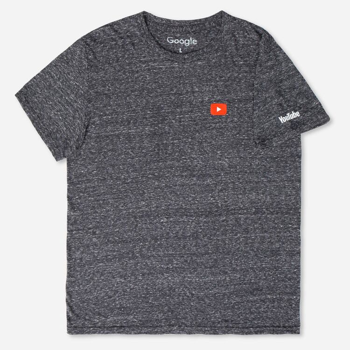

roupa 267


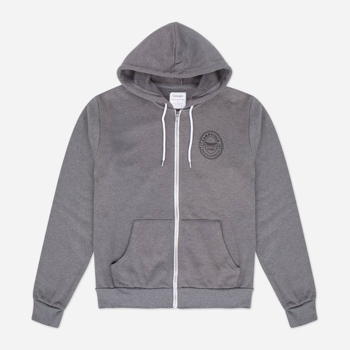

roupa 330


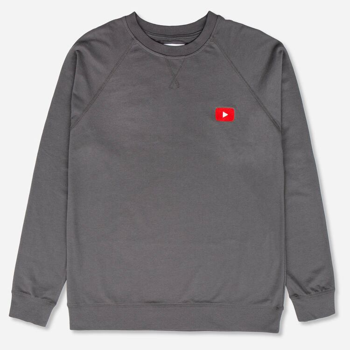

roupa 271


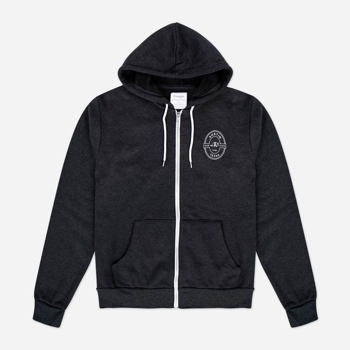


A seguinte imagem é a roupa que o cliente gostou:



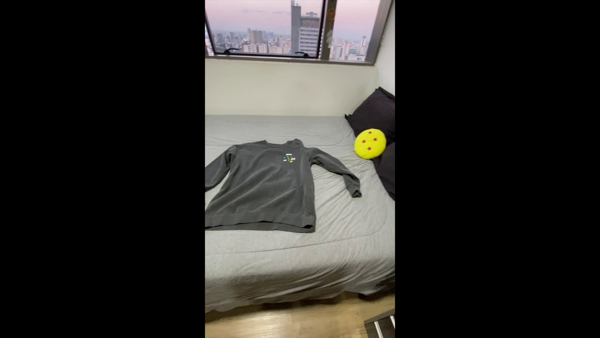


Qual das opções você o cliente gostaria de comprar?
e explique a razão em detalhes


-------Resposta--------
O cliente gostaria de comprar a roupa **330**. 

A roupa da imagem é uma camiseta de manga comprida cinza com o logo do YouTube no lado esquerdo do peito. A roupa 330 corresponde perfeitamente à descrição da roupa da imagem, incluindo a cor, o estilo e o logotipo. 



In [ ]:
product_options = []

for index, product in shortlisted_products.iterrows():  # Iterate directly over rows for clarity
  score = product["score"]
  gcs_path = product["gcs_path"]
  url = get_url_from_gcs(gcs_path)
  product_options.append(f"roupa {index+1}")
  product_options.append(load_image_from_url(url))

prompt = """
Consirede a seguinte opções de roupa:
"""

prompt2 = """
A seguinte imagem é a roupa que o cliente gostou:
"""

liked = Image.load_from_file(roupa["frame_path"])

prompt3 = """
Qual das opções você o cliente gostaria de comprar?
e explique a razão em detalhes
"""

content = [
    prompt,
]

content.extend(product_options)
content.append(prompt2)
content.append(liked)
content.append(prompt3)

print("-------Prompt--------")
print_multimodal_prompt(content)


print("\n-------Resposta--------")

response = multimodal_model.generate_content(content)
print(response.text)